# SENTIMENT ANALYSIS ON US TWITTER AIRLINE DATA

### Importing Packages

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.util import ngrams
from collections import Counter
import string
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

### Importing And Exploring Data

In [2]:
# Importing the data into a pandas dataframe
data = pd.read_csv('Tweets.csv')

In [3]:
# Exploring the data
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760000,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2/24/2015 11:35,NaN,Eastern Time (US & Canada)
1,570301130888122000,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2/24/2015 11:15,NaN,Pacific Time (US & Canada)
2,570301083672813000,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2/24/2015 11:15,Lets Play,Central Time (US & Canada)
3,570301031407624000,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2/24/2015 11:15,NaN,Pacific Time (US & Canada)
4,570300817074462000,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2/24/2015 11:14,NaN,Pacific Time (US & Canada)


In [4]:
# Exploring the data
data.shape

(14640, 15)

In [5]:
# Exploring the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


### Preprocessing the Data

In [6]:
# Calculating the percentage of null values in the columns
(data.isnull().sum()/14640)*100

tweet_id                         0.000000
airline_sentiment                0.000000
airline_sentiment_confidence     0.000000
negativereason                  37.308743
negativereason_confidence       28.128415
airline                          0.000000
airline_sentiment_gold          99.726776
name                             0.000000
negativereason_gold             99.781421
retweet_count                    0.000000
text                             0.000000
tweet_coord                     93.039617
tweet_created                    0.000000
tweet_location                  32.329235
user_timezone                   32.923497
dtype: float64

#### Since airline_sentiment_gold, negativereason_gold, and tweet_coord have over 90% missing values, I am dropping them from my analysis

In [7]:
# Dropping the columns that have a large number of missing values
data = data.drop(['airline_sentiment_gold','negativereason_gold','tweet_coord'],
                 axis=1)

In [8]:
# Extracting the columns that will help me in my analysis
my_data = data.drop(['airline_sentiment_confidence','negativereason_confidence',
                     'tweet_created','tweet_location','user_timezone'],axis=1)

### Sentiment Analysis using Vader

In [9]:
# Initializing the Analyzer
sentiment = SentimentIntensityAnalyzer()

In [41]:
# Creating columns for the polarity scores calculated by the Sentiment Analyzer
my_data['polarity_score'] = my_data['text'].apply(lambda x: sentiment.polarity_scores(str(x))['compound'])
my_data['neutral'] = my_data['text'].apply(lambda x:sentiment.polarity_scores(str(x))['neu'])
my_data['negative'] = my_data['text'].apply(lambda x:sentiment.polarity_scores(str(x))['neg'])
my_data['positive'] = my_data['text'].apply(lambda x:sentiment.polarity_scores(str(x))['pos'])

In [11]:
# Exploring the newly developed columns
display(my_data.loc[:,['text','polarity_score','neutral','negative','positive']].head())

,text,polarity_score,neutral,negative,positive
0,@VirginAmerica What @dhepburn said.,0.0000,1.000,0.000,0.0
1,@VirginAmerica plus you've added commercials t...,0.0000,1.000,0.000,0.0
2,@VirginAmerica I didn't today... Must mean I n...,0.0000,1.000,0.000,0.0
3,@VirginAmerica it's really aggressive to blast...,-0.5984,0.754,0.246,0.0
4,@VirginAmerica and it's a really big bad thing...,-0.5829,0.679,0.321,0.0


### Creating Bins Of Composite Score To Identify Extremes Of Sentiment

In [12]:
# Defining the bins and segmenting data
conditions = [
    (my_data['polarity_score'] <= 1) & (my_data['polarity_score'] >= 0.5),
    (my_data['polarity_score'] < 0.5) & (my_data['polarity_score'] > 0),
    (my_data['polarity_score'] == 0),
    (my_data['polarity_score'] < 0) & (my_data['polarity_score'] >= -0.5),
    (my_data['polarity_score'] < -0.5) & (my_data['polarity_score'] >= -1)]
choices = ['V.Positive', 'Positive', 'Neutral', 'Negative', 'V.Negative']
my_data['Sentiment_Calc'] = np.select(conditions, choices, default='Neutral') # Calculated Sentiment

In [13]:
# Calculating the number of data points in each of the bins
my_data.loc[:,['tweet_id','Sentiment_Calc']].groupby('Sentiment_Calc').nunique()[['tweet_id']]

,tweet_id
Sentiment_Calc,
Negative,3086
Neutral,3237
Positive,3321
V.Negative,2009
V.Positive,2832


### Exploring Topics Discussed In Negative Tweets

In [42]:
# Extracting the Negative Tweets into a new Dataframe and determining the 
#distribution of Negative Reasons
Negative_Tweets = my_data[(my_data['Sentiment_Calc'] == 'Negative') | 
                          (my_data['Sentiment_Calc'] == 'V.Negative')]
Negative_Counts = Negative_Tweets.groupby('negativereason').count()[['tweet_id']]
Negative_Counts

,tweet_id
negativereason,
Bad Flight,289
Can't Tell,535
Cancelled Flight,580
Customer Service Issue,1359
Damaged Luggage,43
Flight Attendant Complaints,277
Flight Booking Problems,212
Late Flight,913
Lost Luggage,334


Text(0.5,0,'Reasons For Negative Tweets')

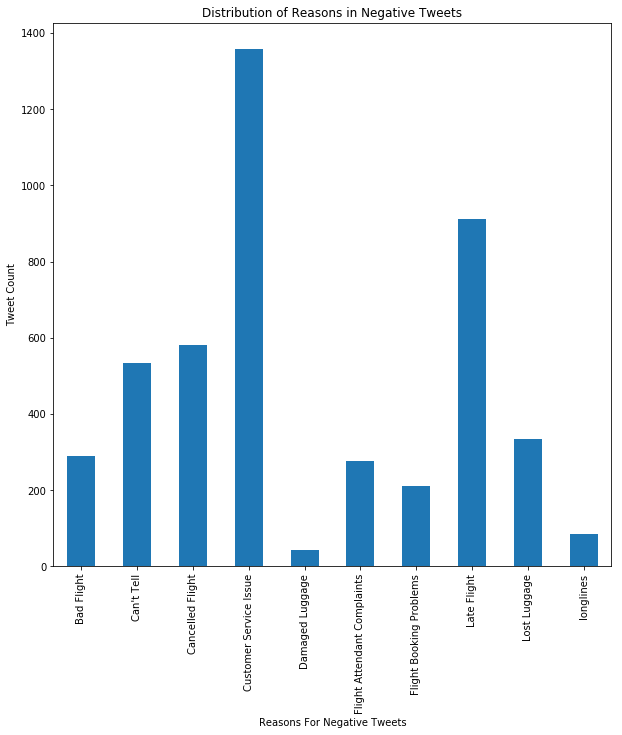

In [15]:
# Plotting the distribution of reasons in negative tweets
ax = Negative_Counts.plot.bar(figsize=(10,10), title="Distribution of Reasons in Negative Tweets", legend=False)
ax.set_ylabel("Tweet Count")
ax.set_xlabel("Reasons For Negative Tweets")

##### When Tweets are negative, customers tend to discuss about Bad Flights, Cancelled Flights, Customer Service Issues, Damaged Luggage, Flight Attendant Complaints, Flight Booking Problems, Late Flights, Lost Luggages, and Long Lines. Customer Service Issues seem to be the most common topic in Negative Tweets.

### Exploring Topics Discussed In Positive Tweets

In [16]:
# Extracting positive tweets from the data
Positive_Tweets = my_data[(my_data['Sentiment_Calc'] == 'Positive') | (my_data['Sentiment_Calc'] == 'V.Positive')]

In [17]:
# Cleaning the tweets and extracting words that interest us
words = ' '.join(Positive_Tweets['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                                and word !='&amp'
                            ])

stopwords = set(STOPWORDS)
stopwords.add("amp")
stopwords.add("flight")
stopwords.add("flights")
stopwords.add("plane")


wordcloud = WordCloud(stopwords=stopwords,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

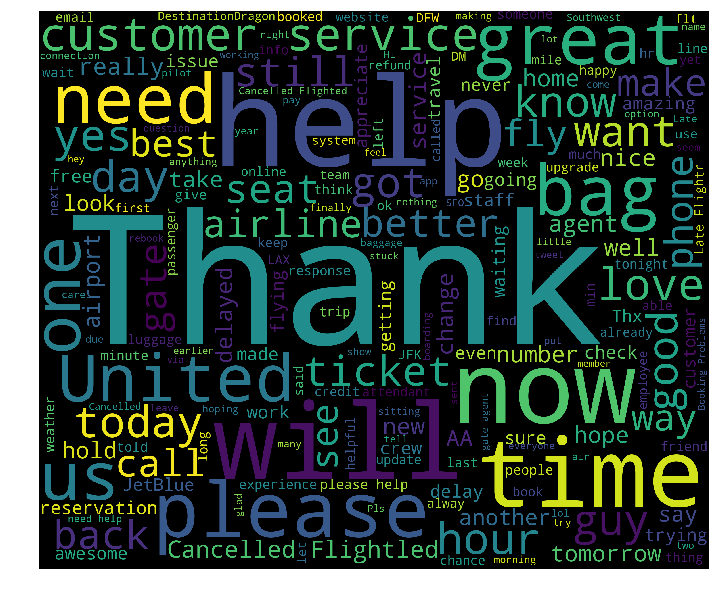

In [18]:
# Plotting the words that appear most frequently in positive tweets
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

##### The positive tweets tend to talk about topics like Customer service, flight experience, weather, upgrades, particular airports (eg:JFK), etc.

##### Using bigrams to analyze the positive tweets:

In [19]:
# Cleaning the words by removing punctuations and stopwords
words = nltk.word_tokenize(cleaned_word)
punt_removed = [w for w in words if w.lower() not in string.punctuation]
clean_words = " ".join(punt_removed)
stop_words = set(STOPWORDS) 
stop_words.add('I')
stop_words.add('\'m')
stop_words.add('ca')
stop_words.add('Ca')
stop_words.add('n\'t')
stop_words.add('it')
stop_words.add('\'s')
stop_words.add('get')
stop_words.add('that')
stop_words.add('That')
word_tokens = nltk.word_tokenize(clean_words) 
  
filtered_sentence = [w for w in word_tokens if not w in stop_words] 
  
filtered_sentence = [] 
  
for w in word_tokens: 
    if w not in stop_words: 
        filtered_sentence.append(w) 
        
filtered_sentence = ' '.join(filtered_sentence)

In [20]:
#Creating a function to extract n-grams from text (current and previous n words for context)
def get_ngrams(txt, n):
    n_grams = ngrams(nltk.word_tokenize(txt),n)
    return [' '.join(grams) for grams in n_grams]

In [21]:
#Extracting bigrams
bigrams = get_ngrams(filtered_sentence, 2)

#Counting bigrams
bigrams_count = Counter(bigrams)

# Creating a dataframe using the bigrams_count
df = pd.DataFrame.from_dict(bigrams_count, orient='index')
df = df.rename(columns={'index':'words', 0:'frequency'})

In [22]:
# Printing the 30 most frequent bigrams from the text
df.sort_values('frequency',ascending=False).head(30)

,frequency
customer service,192
Cancelled Flightled,130
Late Flight,65
Late Flightr,52
Cancelled Flighted,51
flight Cancelled,49
Can help,47
Booking Problems,42
Cancelled Flight,40
please help,40


##### From the bigram-frequency analysis, it is evident that positive tweeets have mentioned the following topics frequently: Customer Service, Great Flights, Gate Agents, Cancelled Flights, Late Flights, First Class, Flight Attendents, Fleet Fleek, etc.

### Systematic Variation In The Tweets Across Different Airlines

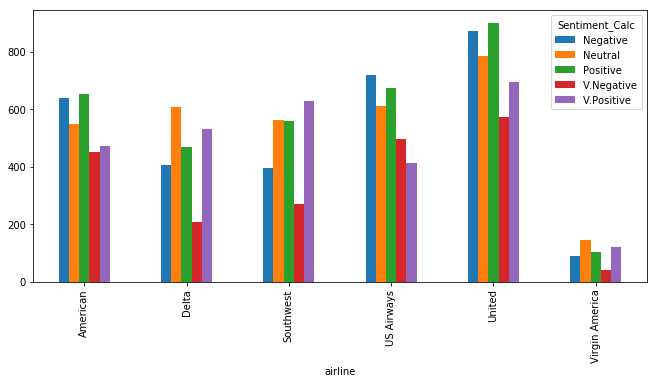

In [23]:
# Distribution of Calculated sentiments across arilines
my_data.groupby(['airline', 'Sentiment_Calc']).size().unstack().plot(kind='bar',figsize=(11, 5))

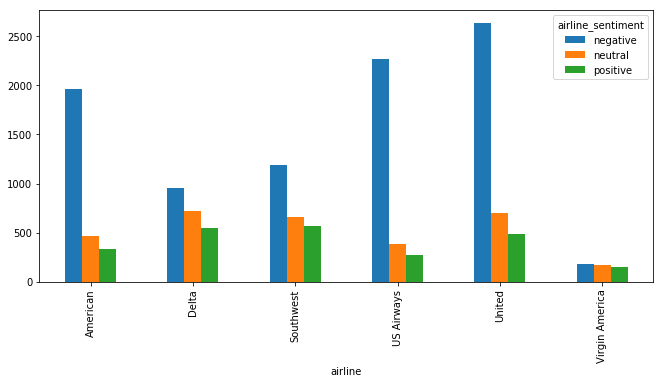

In [24]:
# Distribution of Given sentiments across arilines
my_data.groupby(['airline', 'airline_sentiment']).size().unstack().plot(kind='bar',figsize=(11, 5))

##### We can infer from the graph above that customers mostly tweet when they are agitated. This is evident from the large number of negative tweets compared to the positive and neutral tweets.

##### It is clear from the above graph that most of the tweets are directed at United and most of them are negative. This is probably because of the ticketing-issues that United faced in Feb 2015. [Reference: https://www.businessinsider.com/buy-first-class-tickets-from-london-to-newark-for-50-2015-2?r=UK&IR=T]

In [25]:
# Extracting the tweets directed at United
united_data = my_data[my_data['airline']=='United']

Text(0.5,0,'Reasons For Negative Tweets')

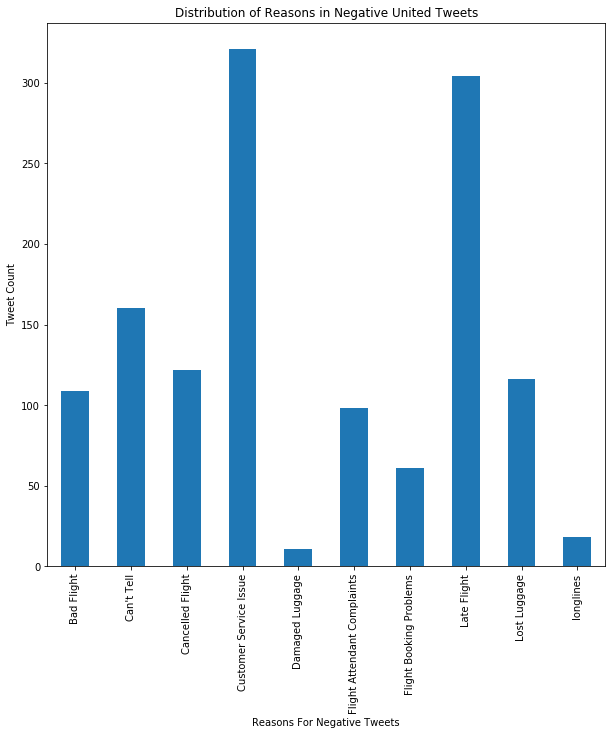

In [26]:
# Extracting the topics in negative tweets directed at United
Negative_United = united_data[(united_data['Sentiment_Calc'] == 'Negative') | (united_data['Sentiment_Calc'] == 'V.Negative')]
United_Counts = Negative_United.groupby('negativereason').count()[['tweet_id']]
ax = United_Counts.plot.bar(figsize=(10,10), title="Distribution of Reasons in Negative United Tweets", legend=False)
ax.set_ylabel("Tweet Count")
ax.set_xlabel("Reasons For Negative Tweets")

##### As expected, we can see that a significant amount of the negative tweets have 'Flight Booking Problems' mentioned as thier reason. 

### Analysis of Re-tweeted Tweets

In [27]:
# Extracting the Tweets that have been retweeted atleast once
re_tweeet = my_data[my_data['retweet_count']>0]

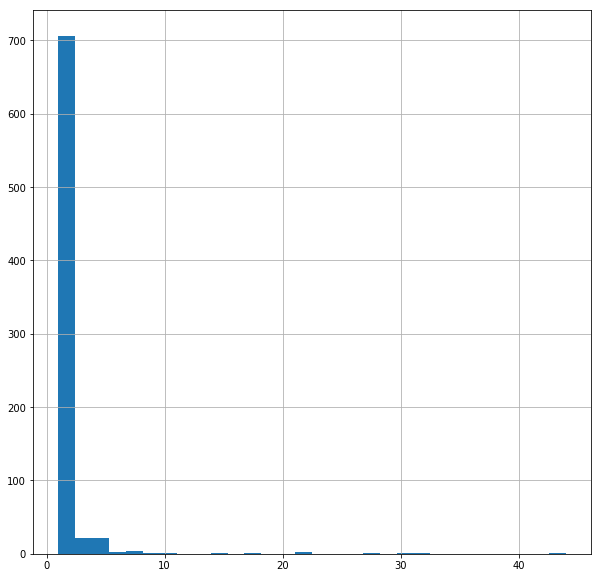

In [28]:
# Analyzing the distribution of retweet_count
re_tweeet['retweet_count'].hist(bins=30,figsize=(10,10))

In [29]:
# Identifying unique values taken by the retweet_count variable
re_tweeet.retweet_count.unique()

array([ 1,  2,  3,  4,  5,  7, 22,  6, 18, 15, 31, 11,  8,  9, 28, 32, 44], dtype=int64)

In [30]:
# Analyzing the polarity of tweets that are re-tweeted
re_tweeet.groupby('airline_sentiment').sum()[['retweet_count']]

,retweet_count
airline_sentiment,
negative,857.0
neutral,189.0
positive,164.0


##### We can clearly see that Negative-tweets tend to be re-tweeted way more than the positive or neutral ones.

In [31]:
# Extracting highly re-tweeted tweets
high_re_tweet = re_tweeet[re_tweeet['retweet_count']>10]
high_re_tweet

,tweet_id,airline_sentiment,negativereason,airline,name,retweet_count,text,polarity_score,neutral,negative,positive,Sentiment_Calc
5607,568869594531651000,positive,NaN,Southwest,seattlefordguy,22,@SouthwestAir beautiful day in Seattle! http:/...,0.6360,0.544,0.000,0.456,V.Positive
7027,569950913554620000,negative,Can't Tell,Delta,AbeFroman,18,"Just in case you needed confirmation that ""on ...",-0.6486,0.815,0.185,0.000,V.Negative
7111,569935592651411000,neutral,NaN,Delta,No_Cut_Card,15,X____x RT @JetBlue: Our fleet's on fleek. http...,0.0000,1.000,0.000,0.000,Neutral
7115,569932678688055000,negative,Can't Tell,Delta,TheBuie,22,can you not? RT @JetBlue Our fleet's on fleek....,0.0000,1.000,0.000,0.000,Neutral
7132,569927288751587000,negative,Can't Tell,Delta,TatianaKing,31,STOP. USING.THIS.WORD. IF. YOU'RE. A. COMPANY....,-0.4466,0.804,0.196,0.000,Negative
7453,569596394819883000,positive,NaN,Delta,OlivierGachot,11,@JetBlue what a great experience on flight fro...,0.7345,0.764,0.000,0.236,V.Positive
9999,569584057270575000,neutral,NaN,US Airways,airliners2,28,@USAirways with this livery back in the day. h...,0.0000,1.000,0.000,0.000,Neutral
11582,567909106553483000,negative,Can't Tell,US Airways,OBJ_3,32,@USAirways of course never again tho . Thanks ...,0.2725,0.830,0.064,0.106,Positive
11596,567897883875217000,negative,Late Flight,US Airways,OBJ_3,44,@USAirways 5 hr flight delay and a delay when ...,-0.5574,0.839,0.161,0.000,V.Negative


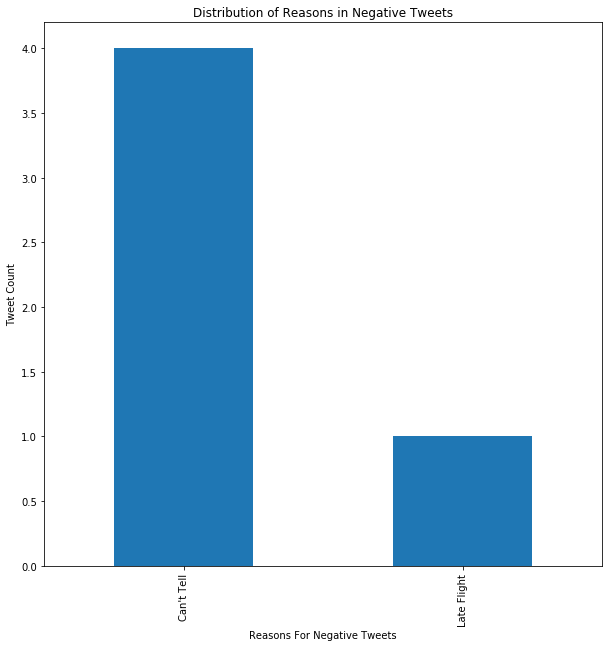

In [32]:
# Extracting the topics in negative tweets that are re-tweeted the most
United_Counts = high_re_tweet.groupby('negativereason').count()[['tweet_id']]
ax = United_Counts.plot.bar(figsize=(10,10), title="Distribution of Reasons in Negative Tweets", legend=False)
ax.set_ylabel("Tweet Count")
ax.set_xlabel("Reasons For Negative Tweets")
plt.show()

### Identifying The Most Negative Customers (Based on Tweet-Polarity)

In [33]:
# Identifying the top-20 most negative customers based on their mean Negative-Polarity-Scores
Negative_Customers = Negative_Tweets.groupby('name').mean()[['negative']].sort_values('negative',ascending=False)
Negative_Customers.head(20)

,negative
name,
chrsmichaels,0.857
ernest_borg9,0.746
WM_j_MW,0.703
sportsguy44,0.692
BenSnider12,0.689
iLoveMakados,0.655
illegalholland,0.649
BigFishRealtor,0.637
KristenElysse,0.636


### Identifying The Most Positive Customers (Based on Tweet-Polarity)

In [34]:
# Identifying the top-20 most positive customers based on their mean Positive-Polarity-Scores
Positive_Customers = Positive_Tweets.groupby('name').mean()[['positive']].sort_values('positive',ascending=False)
Positive_Customers.head(20)

,positive
name,
pir2h,0.898
MeredithAdams23,0.879
SarahM0en,0.873
chi_citygrl,0.861
hirammrom,0.841
JAYXXX1,0.841
RaulFNYC,0.836
ScottSusman,0.833
rzif,0.833


### Average Number Of Airlines A Customer Tweets About

In [35]:
# Calculating the number of airlines each customer tweets about
cust_airline = my_data.groupby(['name','airline']).count()[['tweet_id']]
cust_airline['Airline_Count']=1
cust_airline_count=cust_airline.groupby('name').sum()[['Airline_Count']]
cust_airline_count.head()

,Airline_Count
name,
0504Traveller,2
0veranalyser,1
0xjared,1
10Eshaa,1
1234567890_,1


In [36]:
# Calculating the average number of airlines a customer tweets about
cust_airline_count['Airline_Count'].mean()

1.0283080119465005

##### On an average, a customer tweets about 1.0283080119465005 airlines

### Identifying The Most Active Customers

In [37]:
# Extracting the necessary columns from the dataframe
Active_Cust = my_data.drop(['negativereason','airline','text','Sentiment_Calc','tweet_id'],axis=1)

# Adding a new column to help in the calculation of the number of tweets
Active_Cust['No_of_Tweets'] = 1

In [38]:
# Identifying top-10 Most Active Customers, in terms of number of tweets
Active_Cust.groupby(['name']).sum().sort_values('No_of_Tweets',ascending=False).head(10)

,retweet_count,polarity_score,neutral,negative,positive,No_of_Tweets
name,,,,,,
JetBlueNews,0,8.0530,53.128,2.851,7.026,63
kbosspotter,0,6.5449,25.161,1.094,5.746,32
_mhertz,6,-1.2475,23.798,2.763,2.438,29
otisday,1,-2.4688,22.605,3.288,2.107,28
throthra,3,0.4543,21.838,2.413,2.749,27
rossj987,1,0.1735,19.825,1.632,1.543,23
weezerandburnie,0,-5.2897,19.031,2.882,1.087,23
GREATNESSEOA,0,0.5637,17.554,2.407,2.037,22
MeeestarCoke,0,2.7031,17.691,1.092,3.217,22


##### The most active customer is 'JetBlueNews' with 63 Tweets in Feb 2015. The second most active customer, 'kbosspotter', has almost half (32) the number of Tweets as the most active customer

#### Since there isn't enough data (we have data spanning only the month of Feb) to analyze the time trends in the polarity of tweets, I have avoided the analysis. However, I expect the negative tweets to increase during the holiday season (during Thanksgiving and Christmas) as the demands/expectations on airlines increase significantly with more number of people opting to travel. Additionally, with e-commerce websites providing amazing deals on various products, the good transported through flights will also increase significantly during this time. The over-worked employees may add to the already existing problem of poor customer service faced my most of the airlines.